In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import time
import datetime
import copy
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1

In [2]:
torch.__version__

'1.3.1'

---
# Directory

In [3]:
data_dir = '..\\input'

metadata_path = glob.glob(os.path.join(data_dir, '*.json'))
mov_path = glob.glob(os.path.join(data_dir, '*.mp4'))

In [4]:
metadata_path

['..\\input\\metadata_00.json',
 '..\\input\\metadata_01.json',
 '..\\input\\metadata_02.json',
 '..\\input\\metadata_03.json']

In [5]:
# load metadata
metadata = pd.DataFrame()
for path in metadata_path:
    metadata = pd.concat([metadata, pd.read_json(path).T], axis=0)
    
metadata.reset_index(inplace=True)
metadata = metadata.rename(columns={'index': 'mov'})

In [6]:
metadata.head()

,mov,label,split,original
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,REAL,train,NaN
2,fzvpbrzssi.mp4,REAL,train,NaN
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [7]:
# Label
metadata['label'].value_counts()

FAKE    5593
REAL     643
Name: label, dtype: int64

In [8]:
# 
metadata['original'].value_counts()[metadata[metadata['label'] == 'REAL']['mov']]

mov
vpmyeepbep.mp4    27
fzvpbrzssi.mp4    12
syxobtuucp.mp4    12
dhjnjkzuhq.mp4     8
xcruhaccxc.mp4     3
                  ..
rltsrqhbff.mp4     1
hexyjykhvk.mp4     1
twgobosowv.mp4     1
hwaxcxpfxl.mp4     1
iutieugpqx.mp4     1
Name: original, Length: 643, dtype: int64

In [9]:
metadata[metadata['original'] == 'fzvpbrzssi.mp4']

,mov,label,split,original
123,hjxckindzx.mp4,FAKE,train,fzvpbrzssi.mp4
523,birmbtezni.mp4,FAKE,train,fzvpbrzssi.mp4
589,acagallncj.mp4,FAKE,train,fzvpbrzssi.mp4
591,wyqdbqmbjk.mp4,FAKE,train,fzvpbrzssi.mp4
645,qkzabeimvu.mp4,FAKE,train,fzvpbrzssi.mp4
698,hnalkvbcim.mp4,FAKE,train,fzvpbrzssi.mp4
842,roqbnlondz.mp4,FAKE,train,fzvpbrzssi.mp4
894,rixpoeqiaq.mp4,FAKE,train,fzvpbrzssi.mp4
995,pktyfrvywo.mp4,FAKE,train,fzvpbrzssi.mp4
1103,rfeagdwnnn.mp4,FAKE,train,fzvpbrzssi.mp4


In [10]:
video_1 = os.path.join(data_dir, 'hjxckindzx.mp4')
video_2 = os.path.join(data_dir, '	birmbtezni.mp4')
video_real = os.path.join(data_dir, 'fzvpbrzssi.mp4')

---
# Movie to Image

In [11]:
def get_img_from_mov(video_file, show_img=False):
    # https://note.nkmk.me/python-opencv-videocapture-file-camera/
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    image_list = []
    for i in range(frames):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
    cap.release()

    if show_img:
        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        ax.imshow(image[0])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
        plt.grid(False)
        
    return image_list

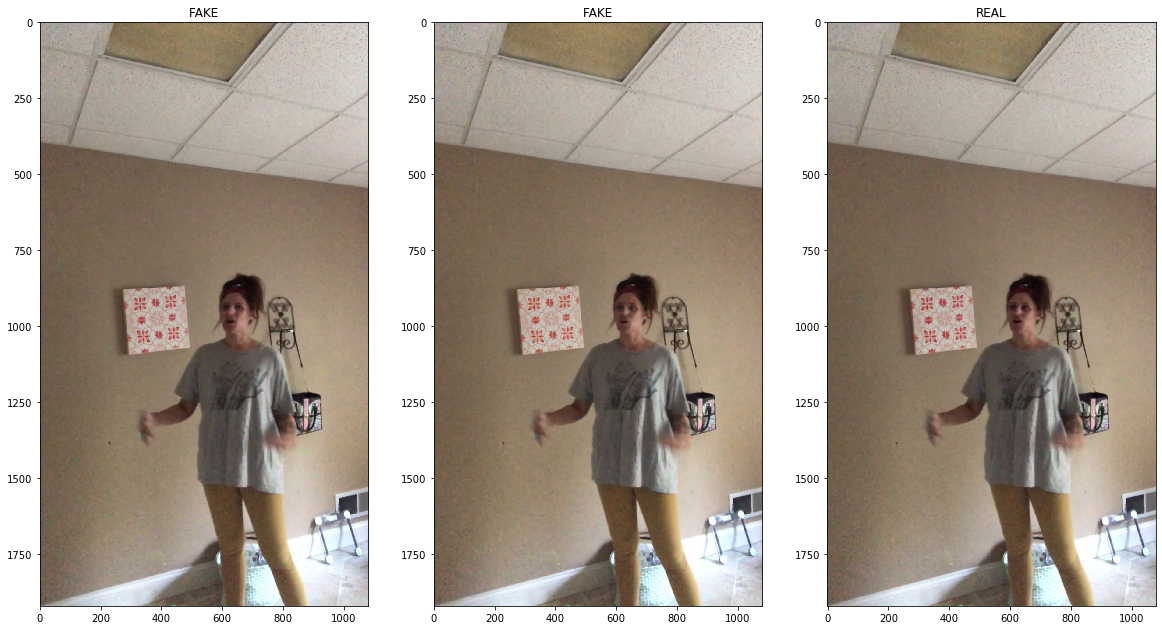

In [12]:
image_1 = get_img_from_mov(video_1)
image_2 = get_img_from_mov(video_2)
image_real = image = get_img_from_mov(video_real)

fig, axes = plt.subplots(1, 3, figsize=(20, 14), facecolor='w')

axes[0].imshow(image_1[50])
axes[0].set_title('FAKE')
axes[1].imshow(image_2[50])
axes[1].set_title('FAKE')
axes[2].imshow(image_real[50])
axes[2].set_title('REAL')
plt.show()

---
# Face Detection

In [37]:
def detect_face(img):
    # Add Dataset "Haarcascades"
    face_cascade = cv2.CascadeClassifier('..\\haarcascade\\haarcascade_frontalface_alt.xml')
    face_crops = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    
    if len(face_crops) == 0:
        return []
    print(face_crops)
    
    crop_imgs = []
    for i in range(len(face_crops)):
        x = face_crops[i][0]
        y = face_crops[i][1]
        w = face_crops[i][2]
        h = face_crops[i][3]
        #x,y,w,h=ratio*x,ratio*y,ratio*w,ratio*h
        crop_imgs.append(img[y:y+h, x:x+w])
    return crop_imgs

[[570 890 123 123]]
[[570 894 113 113]]
[[576 897 110 110]]


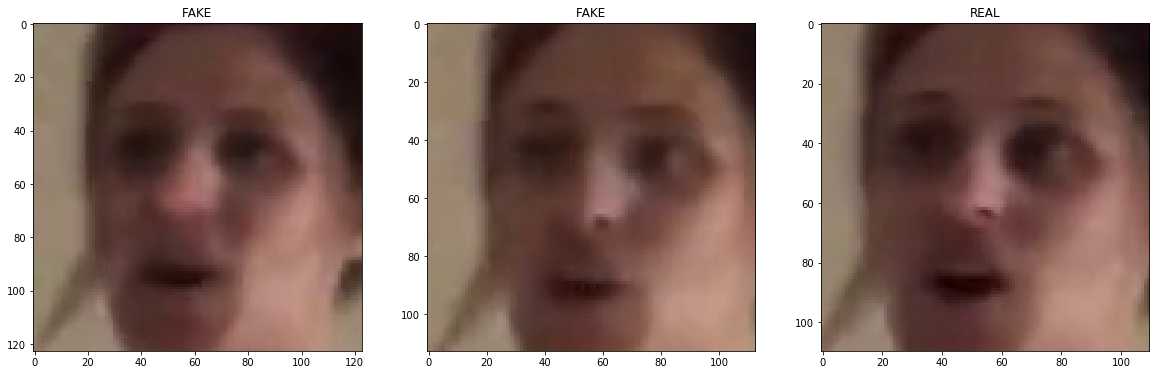

In [38]:
image_crop_1 = detect_face(image_1[50])
image_crop_2 = detect_face(image_2[50])
image_crop_real = detect_face(image_real[50])

fig, axes = plt.subplots(1, 3, figsize=(20, 14), facecolor='w')

axes[0].imshow(image_crop_1[0])
axes[0].set_title('FAKE')
axes[1].imshow(image_crop_2[0])
axes[1].set_title('FAKE')
axes[2].imshow(image_crop_real[0])
axes[2].set_title('REAL')
plt.show()

In [16]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and, given raw input images as PIL images,
 |  returns images cropped to include the face only. Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the davidsandberg/facenet
 |          repo, which applies the margin to the original image before resizing, making the margin
 |          dependent on the original image size (this is a b

In [44]:
def detect_face_mtcnn(img):
    _img = img[np.newaxis, :, :, :]
    mtcnn = MTCNN(keep_all=True)
    boxes, probs, points = mtcnn.detect(_img, landmarks=True)
    x = int(boxes[0][0][0])
    y = int(boxes[0][0][1])
    z = int(boxes[0][0][2])
    w = int(boxes[0][0][3])
    crop_img = img[y:w, x:z]
    return crop_img

In [47]:
crop_img = detect_face_mtcnn(image_1[10])

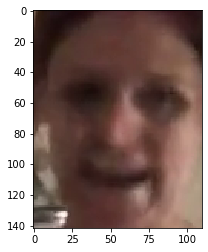

In [48]:
plt.imshow(crop_img)

In [49]:
resize_img = cv2.resize(crop_img, (224, 224))

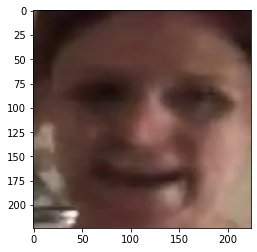

In [50]:
plt.imshow(resize_img)

In [51]:
points

array([[[[827.92477572, 926.69742349],
         [876.36126482, 925.07302985],
         [852.18654931, 951.29289335],
         [832.71887243, 977.6395092 ],
         [874.2278465 , 977.22390503]]]])

---
# Search Face Detection

In [15]:
# Find Movie which cannot detect face
def detect_noface_mov(mov_path, search_img_num=None):
    no_face_detect_mov = []

    for mov in tqdm(mov_path):
        # VideoCapture
        image = get_img_from_mov(mov)
        flag = 0
        
        if search_img_num is None:
            num = len(image)
        else:
            num = search_img_num + 1
        
        for idx in range(num):
            crop = detect_face(image[idx])

            if crop != []:
                flag += 1
            else:
                pass

        if flag == 0:
            no_face_detect_mov.append(mov)
        else:
            pass
    
    df = pd.DataFrame({
        'id': np.arange(len(no_face_detect_mov)),
        'mov': no_face_detect_mov
    })
        
    return df

In [16]:
# no_face_detect_mov_frame = detect_noface_mov(mov_path, search_img_num=0)
# no_face_detect_mov_frame.to_csv('../input/no_face_mov_01.csv', index=False)

---
# Dataset

In [17]:
class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image

# Data Augumentation
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
#                 transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
#                 transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)


class DeepfakeDataset(Dataset):
    def __init__(self, file_list, metadata, transform=None, phase='train'):
        self.file_list = file_list
        self.metadata = metadata
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        mov_path = self.file_list[idx]
        # first frame image only
        image = get_img_from_mov(mov_path, show_img=False)[0]
        # FaceCrop
        image = detect_face(image)[0]
        # Transform
        image = self.transform(image, self.phase)
        
        # Label
        label = self.metadata[self.metadata['mov'] == mov_path.split('\\')[-1]]['label'].values
        
        if label == 'FAKE':
            label = 1
        else:
            label = 0
        
        return image, label, mov_path

In [18]:
# All Mp4 List
mov_path = glob.glob(os.path.join(data_dir, '*.mp4'))

# No Face Mov List
no_face_list = pd.read_csv('../input/no_face_mov_01.csv')

# Only Face Detected Movie List
mov_path = [path for path in mov_path if path.split('\\')[-1] not in no_face_list['mov'].tolist()]
len(mov_path)

895

In [19]:
# Divide Train, Valid Dataset
train_mov_path, val_mov_path = train_test_split(mov_path, test_size=0.1)
print('Train: ', len(train_mov_path))
print('Valid: ', len(val_mov_path))

Train:  805
Valid:  90


In [20]:
# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
train_dataset = DeepfakeDataset(train_mov_path, metadata, ImageTransform(size, mean, std), 'train')
val_dataset = DeepfakeDataset(val_mov_path, metadata, ImageTransform(size, mean, std), 'val')

Operation Check
torch.Size([3, 224, 224])
0


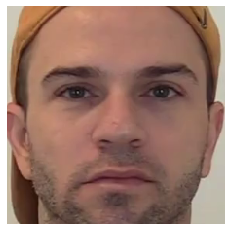

In [43]:
print('Operation Check')
index = 57
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
tt = train_dataset.__getitem__(index)[0].permute(1, 2, 0).numpy()
plt.imshow(tt)
plt.axis('off')
plt.show()

In [26]:
train_dataset.__getitem__(0)[0].size()


torch.Size([3, 224, 224])

In [29]:
image = torch.ones((3, 224, 224), dtype=torch.float)
image.size()

torch.Size([3, 224, 224])

---
# DataLoader

In [30]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [31]:
print('Operation Check')
iterator = iter(train_dataloader)
imgs, label, _ = next(iterator)
print(imgs.size())
print(label)

Operation Check
torch.Size([4, 3, 224, 224])
tensor([1, 1, 1, 1])


---
# Model

In [32]:
# VGG16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# Change Last Layer
# Output Features 1000 → 2
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print('Done')

Done


In [34]:
# Specify The Layers for updating
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
print('Done')

Done


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

---
# Train

In [48]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels, _ in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [49]:
# Train
num_epoch = 2
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/2
--------------------


d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.4541 Acc: 0.8845



val Loss: 0.3210 Acc: 0.9000
Epoch 2/2
--------------------



train Loss: 0.5094 Acc: 0.8621



val Loss: 0.6443 Acc: 0.8889
Training complete in 103m 43s
Best val Acc: 0.900000


In [51]:
# Save Model
date = datetime.datetime.now().strftime('%Y%m%d')
torch.save(net.state_dict(), "../model/vgg16_ep{}_{}.pth".format(num_epoch, date))

In [62]:
# Prediction
label_list = []
pred_list = []
path_list = []

with torch.no_grad():
    for img, label, mov_path in tqdm(val_dataset):
        img = img.unsqueeze(0)
        img = img.to(device)

        net.eval()

        outputs = net(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        label_list.append(label)
        pred_list.append(preds[0])
        path_list.append(mov_path)
    
res = pd.DataFrame({
    'label': label_list,
    'pred': pred_list,
    'path': path_list
})

res.to_csv('../output/submission.csv', index=False)

d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [63]:
res

,label,pred,path
0,1,0.938446,..\input\uzcpzcdwfv.mp4
1,0,0.795264,..\input\nswtvttxre.mp4
2,1,0.763813,..\input\lqrfjiteca.mp4
3,1,0.943662,..\input\pbadlmyohy.mp4
4,1,0.567117,..\input\getmctvhmd.mp4
...,...,...,...
85,1,0.927722,..\input\bnitzihcqs.mp4
86,1,0.948045,..\input\yuteraqwck.mp4
87,1,0.880322,..\input\hfedtplyys.mp4
88,1,0.619810,..\input\cnbxddelwb.mp4


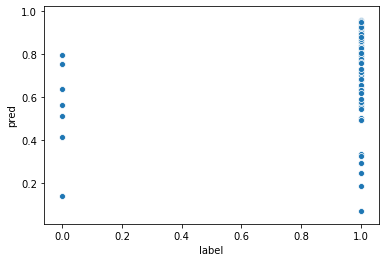

In [65]:
import seaborn as sns
sns.scatterplot(x='label', y='pred', data=res)

In [69]:
torch.save(net.to('cpu'), '../output/vgg16_ep{}_2.pth')